# Boston Marathon Results with Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

In [2]:
raw_df = pd.read_csv('results.csv')
raw_df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
raw_df.describe()

,division,age,official,genderdiv,overall,pace
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,1932.563032,42.407079,242.997314,8051.044741,15939.587825,9.275658
std,1715.228694,11.316496,52.300431,4754.005626,9232.978224,1.992486
min,1.000000,18.000000,80.600000,1.000000,1.000000,3.080000
25%,610.000000,33.000000,205.527500,3972.000000,7943.750000,7.850000
50%,1425.000000,42.000000,232.370000,7970.000000,15939.500000,8.870000
75%,2611.000000,50.000000,273.235000,11968.000000,23935.250000,10.430000
max,6979.000000,81.000000,538.880000,17575.000000,31931.000000,20.570000


The primary features we're looking at here are 'official' (final time), age, gender, and country. The split times are badly formatted and aren't worth cleaning up for this first look at the data. Most of the other features are rankings and bib numbers, which we don't really care about (or can be derived from other data). Let's put all those into a dataset and one hot encode the countries.

In [9]:
# Get the useful columns
df = raw_df.loc[:, ['official', 'age', 'gender', 'genderdiv', 'country']]

# Switch from M/F to 0 for Male, 1 for Female
df.gender = np.where(df.gender == 'M', 0, 1)

# Get Dummies on Country Feature
df = pd.get_dummies(df)

df.head()

,official,age,gender,genderdiv,country_ARG,country_AUS,country_AUT,country_BAH,country_BAR,country_BEL,...,country_TPE,country_TRI,country_TUR,country_UAE,country_UKR,country_URU,country_USA,country_VEN,country_VGB,country_ZIM
0,85.25,47,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,138.95,33,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80.60,41,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,140.58,24,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,81.23,40,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

In [16]:
# Create arrays for modeling
# We'll use two equally sized groups to test our scores for consistency.
X1, X2 = train_test_split(df, test_size = .5)
print('Array shapes:', X1.shape, X2.shape)

Array shapes: (15992, 82) (15992, 82)


Let's just run a quick KMeans to see how the data looks, and if it's easily clustered.

In [11]:
# Run KMeans
km = KMeans(n_clusters=10).fit(X1)
labels = km.labels_

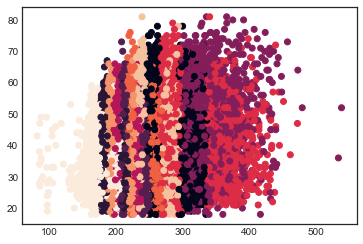

In [12]:
# Plot just based on age and final score
plt.scatter(X1.iloc[:, 0], X1.iloc[:, 1], c=labels)
plt.show()

So K-Means doesn't have a lot to work with here since we don't have a ground truth, and we need a way to determine how many clusters there should be. Let's run a silhouette score for different numbers and see what looks good.

In [19]:
for n_clust in range(2, 9):
    model1 = KMeans(n_clusters=n_clust).fit(X1)
    labels1 = model1.labels_
    model2 = KMeans(n_clusters=n_clust).fit(X2)
    labels2 = model2.labels_
    print('Scores with {} clusters:'.format(n_clust), silhouette_score(X1, labels1, metric='euclidean'), silhouette_score(X2, labels2, metric='euclidean'))

Scores with 2 clusters: 0.617481913183 0.617659300622
Scores with 3 clusters: 0.577942284217 0.575351474298
Scores with 4 clusters: 0.555464779072 0.555025246459
Scores with 5 clusters: 0.544112873597 0.545203153246
Scores with 6 clusters: 0.549539969274 0.549902033275
Scores with 7 clusters: 0.546554976193 0.549004573411
Scores with 8 clusters: 0.544754784763 0.544045977526


It looks like the data fits best with fewer clusters -- 2 clusters gives the best silhouette score. Let's see how it broke up the data.

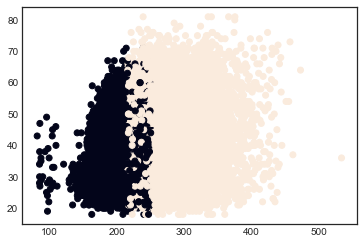

In [20]:
km = KMeans(n_clusters=2).fit(X1)
labels = km.labels_
plt.scatter(X1.iloc[:, 0], X1.iloc[:, 1], c=labels)
plt.show()

We basically have 'fast' and 'slow' here, with some slight variation along the border based on other variables not captured in the plot. Let's dig into those a bit.

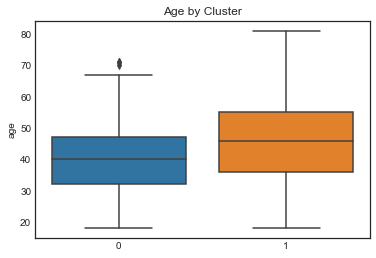

In [35]:
sns.boxplot(x=labels, y='age', data=X1)
plt.title('Age by Cluster')
plt.show()

Cluster 0 is a bit younger than Cluster 1 -- this may be a byproduct of the fact that final time is so important in the cluster separation (as we'll see next).

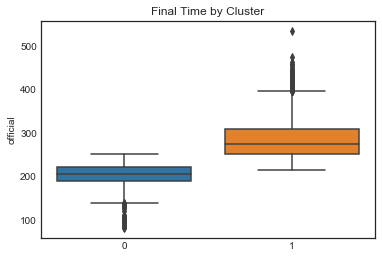

In [36]:
sns.boxplot(x=labels, y='official', data=X1)
plt.title('Final Time by Cluster')
plt.show()

It looks like Official Time is the main deciding factor in separating these clusters. Cluster 0 is almost entirely faster than Cluster 1.

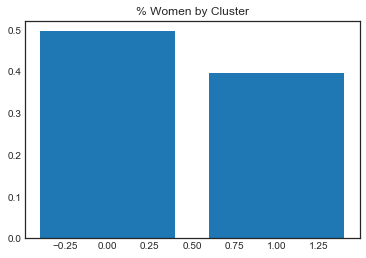

In [73]:
# Plot the sum of the gender feature (only captures women) divided by the number in each cluster.
plt.bar([0, 1], [X1[labels==0].gender.mean(), X1[labels==1].gender.mean()])
plt.title('% Women by Cluster')
plt.show()

This is really interesting -- Cluster 0 has a higher percentage of women than Cluster 1, even though women's average times are about 20 minutes slower than men. I think we might get some insight into this in our next plot.

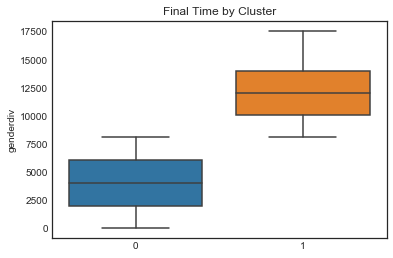

In [74]:
sns.boxplot(x=labels, y='genderdiv', data=X1)
plt.title('Final Time by Cluster')
plt.show()

Ah -- this is where the real division is happening. Our algorithm has basically just sorted the top half of finishers from the bottom half. Including this variable was probably a mistake, as in can be derived from gender and time, and so is being weighted extra. Let's try again without it. Also we didn't normalize -- let's add that too.

In [75]:
# Get the useful columns
df = raw_df.loc[:, ['official', 'age', 'gender', 'country']]

# Switch from M/F to 0 for Male, 1 for Female
df.gender = np.where(df.gender == 'M', 0, 1)

# Get Dummies on Country Feature
df = pd.get_dummies(df)

df.head()

,official,age,gender,country_ARG,country_AUS,country_AUT,country_BAH,country_BAR,country_BEL,country_BER,...,country_TPE,country_TRI,country_TUR,country_UAE,country_UKR,country_URU,country_USA,country_VEN,country_VGB,country_ZIM
0,85.25,47,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,138.95,33,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80.60,41,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,140.58,24,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,81.23,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# Create arrays for modeling
# We'll use two equally sized groups to test our scores for consistency.
X1, X2 = train_test_split(df, test_size = .5)
X1_norm = normalize(X1)
X2_norm = normalize(X2)
print('Array shapes:', X1.shape, X2.shape)

Array shapes: (15992, 81) (15992, 81)


In [81]:
for n_clust in range(2, 9):
    model1 = KMeans(n_clusters=n_clust).fit(X1_norm)
    labels1 = model1.labels_
    model2 = KMeans(n_clusters=n_clust).fit(X2_norm)
    labels2 = model2.labels_
    print('Scores with {} clusters:'.format(n_clust), silhouette_score(X1, labels1, metric='euclidean'), silhouette_score(X2, labels2, metric='euclidean'))

Scores with 2 clusters: 0.176608766854 0.166080041526
Scores with 3 clusters: 0.0133870358261 0.0121862035794
Scores with 4 clusters: -0.0523766706872 -0.0534881373562
Scores with 5 clusters: -0.0901869187003 -0.0913101142236
Scores with 6 clusters: -0.111814409092 -0.111483520533
Scores with 7 clusters: -0.133243463478 -0.131484071364
Scores with 8 clusters: -0.146065992941 -0.143460905824


After normalizing, we've weakened the importance of the "Official Time" variable, and made all our clusters less effective. We still do the best with only 2 clusters, but we're not doing as well as before. Let's see how it looks.

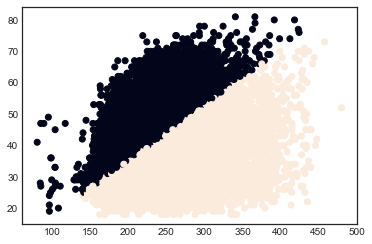

In [82]:
# Fit the model with two clusters and visualize it on the original (non-normalized) data.
# Again, just looking at age and time.

km = KMeans(n_clusters=2).fit(X1_norm)
labels = km.labels_
plt.scatter(X1.iloc[:, 0], X1.iloc[:, 1], c=labels)
plt.show()

By normalizing, we made the 'age' feature equally important as the 'time' feature. Our split is now along the ('age' + 'time' = constant) line. This isn't a very useful way of looking at the data, but let's see if we can draw anything out of our individual variables.

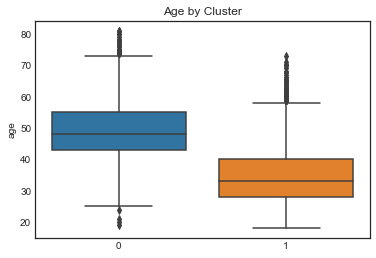

In [83]:
sns.boxplot(x=labels, y='age', data=X1)
plt.title('Age by Cluster')
plt.show()

Cluster 0 contains the older segment of the group, and the difference if more noticeable than before we normalized.

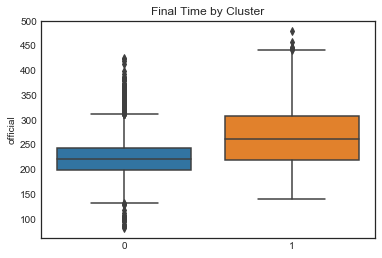

In [84]:
sns.boxplot(x=labels, y='official', data=X1)
plt.title('Final Time by Cluster')
plt.show()

Cluster 0 grabbed the faster segment of the group as well, although not by a lot. It did get all the fastest times, but also some of the slowest.

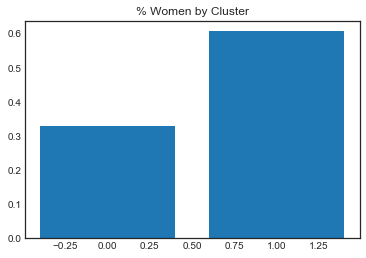

In [85]:
# Plot the sum of the gender feature (only captures women) divided by the number in each cluster.
plt.bar([0, 1], [X1[labels==0].gender.mean(), X1[labels==1].gender.mean()])
plt.title('% Women by Cluster')
plt.show()

This is a big change -- women are now significantly more likely to be in Cluster 1 (younger + slower) than in Cluster 0 (old + fast). Still, these groupings all seem pretty arbitrary. Let's see what KMeans does with more clusters, even though the silhouette score wasn't as good. Also, I have a feeling the 'Country' feature might be playing too big a role here. Let's remove it and try one more time.

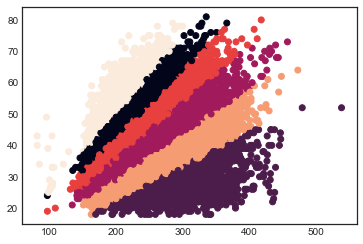

In [102]:
# Fit the model with six clusters and visualize it on the original (non-normalized) data.
# Again, just looking at age and time.

km = KMeans(n_clusters=6).fit(X1_norm)
labels = km.labels_
plt.scatter(X1.iloc[:, 0], X1.iloc[:, 1], c=labels)
plt.show()

In [87]:
# Get the useful columns
df = raw_df.loc[:, ['official', 'age', 'gender']]

# Switch from M/F to 0 for Male, 1 for Female
df.gender = np.where(df.gender == 'M', 0, 1)

df.head()

,official,age,gender
0,85.25,47,0
1,138.95,33,1
2,80.60,41,0
3,140.58,24,1
4,81.23,40,0


In [88]:
# Create arrays for modeling
# We'll use two equally sized groups to test our scores for consistency.
X1, X2 = train_test_split(df, test_size = .5)
X1_norm = normalize(X1)
X2_norm = normalize(X2)
print('Array shapes:', X1.shape, X2.shape)

Array shapes: (15992, 3) (15992, 3)


In [89]:
for n_clust in range(2, 9):
    model1 = KMeans(n_clusters=n_clust).fit(X1_norm)
    labels1 = model1.labels_
    model2 = KMeans(n_clusters=n_clust).fit(X2_norm)
    labels2 = model2.labels_
    print('Scores with {} clusters:'.format(n_clust), 
          silhouette_score(X1, labels1, metric='euclidean'), 
          silhouette_score(X2, labels2, metric='euclidean'))

Scores with 2 clusters: 0.175497757529 0.168100037037
Scores with 3 clusters: 0.0114373274094 0.0131276767675
Scores with 4 clusters: -0.0529974743773 -0.0556652953045
Scores with 5 clusters: -0.0902744174516 -0.0901738805636
Scores with 6 clusters: -0.113504636369 -0.111338539068
Scores with 7 clusters: -0.132636300532 -0.130756456755
Scores with 8 clusters: -0.146346843574 -0.138006000392


Well, the fit isn't any better. Let's try some other algorithms.

In [100]:
bandwidth = estimate_bandwidth(X1_norm, quantile=0.1, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X1_norm)
labels1 = ms.labels_
bandwidth = estimate_bandwidth(X2_norm, quantile=0.1, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X2_norm)
labels2 = ms.labels_
print('Scores with Mean Shift:'.format(n_clust), 
        silhouette_score(X1, labels1, metric='euclidean'), 
        silhouette_score(X2, labels2, metric='euclidean'))

Scores with Mean Shift: -0.0154717423875 -0.0343478319889


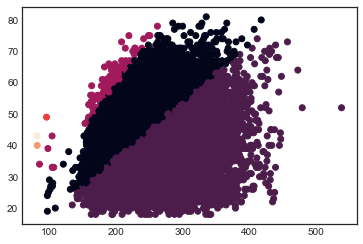

In [101]:
# Fit the model with Mean Shift and visualize it on the original (non-normalized) data.
# Again, just looking at age and time.

bandwidth = estimate_bandwidth(X1_norm, quantile=0.1, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X1_norm)
labels = ms.labels_
plt.scatter(X1.iloc[:, 0], X1.iloc[:, 1], c=labels)
plt.show()

Hmm... Same shape results as KMeans, but different widths for the swaths of age vs. time. I really want sometime to classify 'young and fast', 'old and fast', 'young and slow', 'old and slow', etc, but nothing seems to see the data that way.

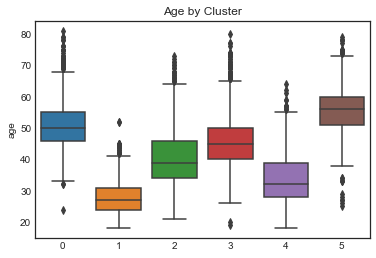

In [103]:
sns.boxplot(x=labels, y='age', data=X1)
plt.title('Age by Cluster')
plt.show()

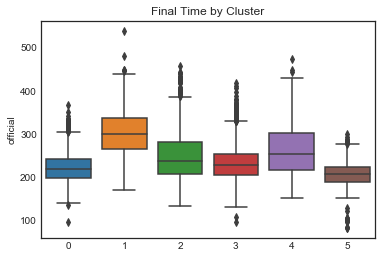

In [104]:
sns.boxplot(x=labels, y='official', data=X1)
plt.title('Final Time by Cluster')
plt.show()

Well, none of this has really worked all that well. The data doesn't *look* like it should be easy to cluster, so it's not surprising that we're having trouble -- it's basically just a mass of points with no clear separation. The best results we got were with just two clusters, and I think were actually more meaningful before normalization. We simply separated between fast and slow.